# Weather Trends Over The Decades
----

I am using data from NOAA to show weather data for the Lexington, Kentucky region over the years.  We are luck enough to have a massive amount of data available to us starting from the late 1940s. 

My thought process is this: it seems that every year the summers are hotter and hotter, the winters not as cold, and lots of extremes throughout the year.  With this data, will we see a trend upwards in the average temperatures? Is the max temperature steadily going up, or staying about the same?  How about the miniumum temperature? Is the percipitation changing as well? 

In [20]:
import pandas as pd
import numpy as np
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# SETTING UP THE DB INFO
DB_PATH = os.path.join('data', 'weather.db')

conn = sqlite3.connect(DB_PATH)

In [22]:
# Fetching the data from the DB and joining the two tables based off the DATE column #
def fetch_data(conn: sqlite3.Connection) -> pd.DataFrame:
    """
    Returns a dataframe based off the weather_dailies and weather_main in the tables.
    We will be JOINing the two tables based off the DATE column.  
    I will average the TMAX, TMIN, and TAVG columns from the weather_dailies table, as there are more than one rows per day.
    """

    query =  """
    WITH d AS (
        SELECT 
            DATE,
            MAX(CAST(TMAX AS DECIMAL(10, 2))) AS TMAX,
            MIN(CAST(TMIN AS DECIMAL(10, 2))) AS TMIN,
            AVG(CAST(TAVG AS DECIMAL(10, 2))) AS TAVG
        FROM weather_dailies
        GROUP BY DATE
    )
    SELECT 
        m.DATE,
        m.SEASON,
        m.YEAR,
        m.DATA_SOURCE,
        m.STATION,
        m.NAME,
        m.TEMP,
        m.PRCP,
        m.DEWP,
        d.TMAX,
        d.TMIN,
        d.TAVG
    FROM weather_main m
    LEFT JOIN d
    ON m.DATE = d.DATE
    ORDER BY m.DATE;
    """
    
    return pd.read_sql_query(query, conn, parse_dates=["DATE"])

df_main = fetch_data(conn)

### Average Annual Temperature 

For the first plot, I figured a basic overview of the data to see what it shows would be the best place to start.  For this graph, I took the average temperature for the year, based off of the average temperature of each day, and plotted each point.  I also decided to drop off the data we have so far for 2025, since this data is incomplete and will subsequently create an unintential outlier. 


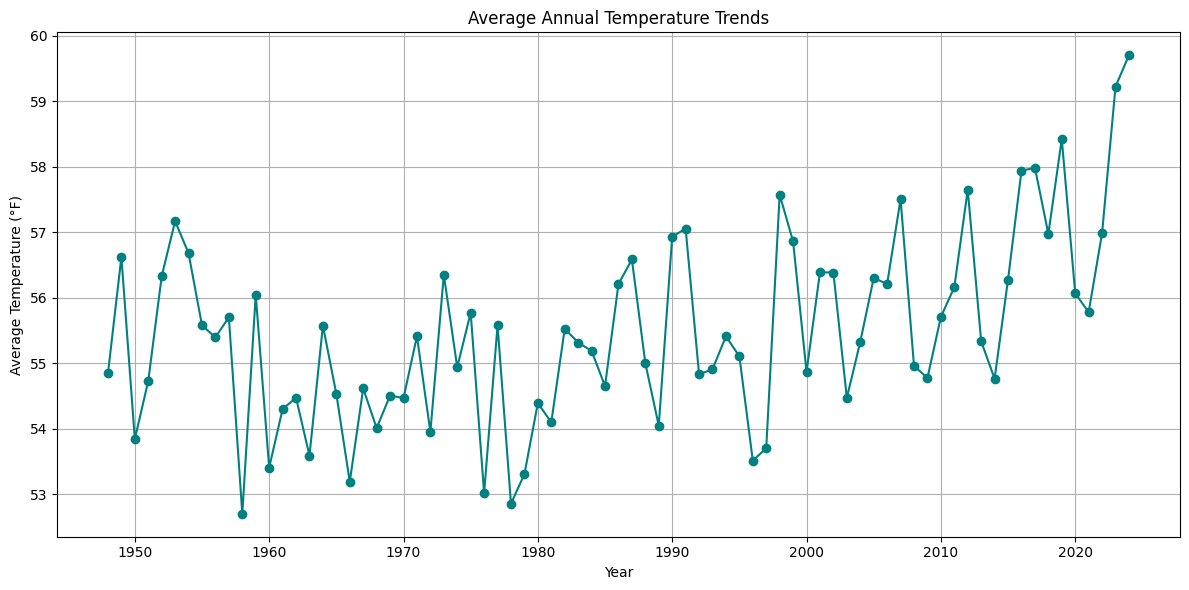

In [23]:
# Temperature TRENDS over the years #
# A very basic look at the temperature trends over the years #

yearly_data = df_main.groupby('YEAR')['TEMP'].mean().reset_index()

# Removing 2025 from the data as it is not complete
yearly_data_wo25 = yearly_data[yearly_data['YEAR'] != 2025]

plt.figure(figsize=(12,6))
plt.plot(yearly_data_wo25['YEAR'], yearly_data_wo25['TEMP'], marker='o', linestyle='-', color='teal')
plt.title('Average Annual Temperature Trends')
plt.xlabel('Year') 
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.tight_layout() 
plt.show()

Two things that I noticed:

-  There definitely is a slight trend upwards in the average temperature for the year. 
-  That the yearly average is not above 60°F, which was very interesting to me.  I was expecting this to be a bit higher, honestly.  Which led me to plot out and check out the max temperatures for the years.

----

### Average max average temperature trends

For this plot, we're looking at the max AVERAGE temperature since 2000.  Because there was only so much data available with daily highs and lows, I limited my range for these values to the 2000s.  This is nearly 25 years worth of data, and we are including data from 2025 - this information ends in July.  Since this will skew the data for 2025, I will remove it from some of the graphs before plotting.  I will make sure to note if the data is removed.

For the Average Max Temp graph, I did remove the data for 2025.

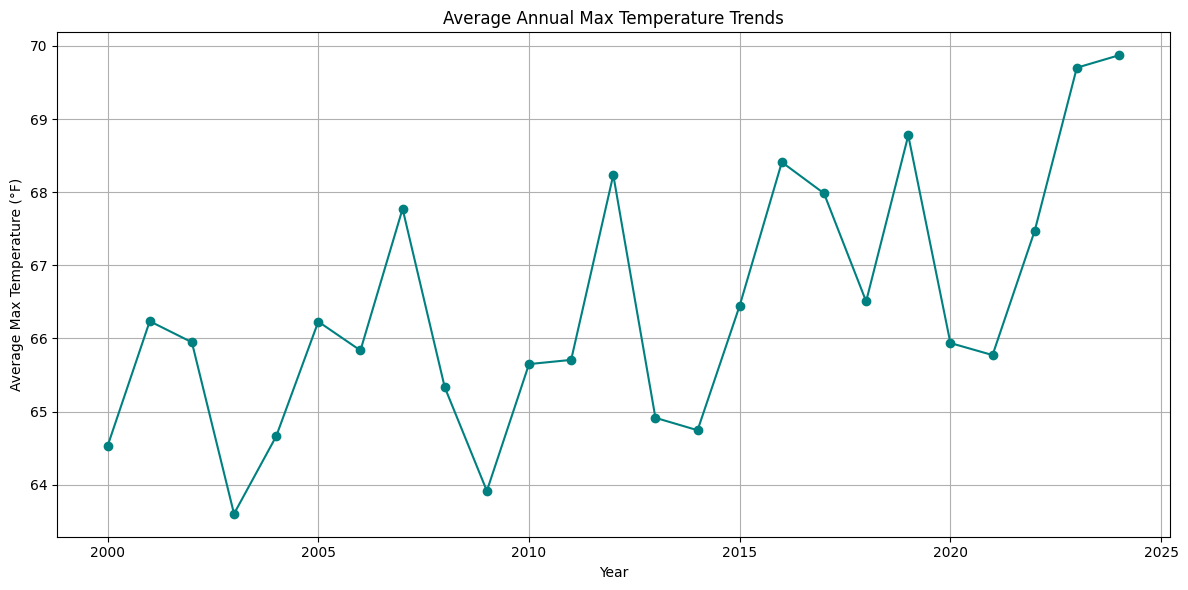

In [24]:
# Max temperature trends over the years #
# Seeing the average increase, but stay below 60 is interesting.. 

yearly_data = df_main.groupby('YEAR')['TMAX'].mean().reset_index()

yearly_data_wo25 = yearly_data[yearly_data['YEAR'] != 2025]

plt.figure(figsize=(12,6))
plt.plot(yearly_data_wo25['YEAR'], yearly_data_wo25['TMAX'], marker='o', linestyle='-', color='teal')
plt.title('Average Annual Max Temperature Trends')
plt.xlabel('Year') 
plt.ylabel('Average Max Temperature (°F)')
plt.grid(True)
plt.tight_layout() 
plt.show()

### Max and Min temperature for the year

The next two graphs, I plotted what the max and minimum temperature was for the year.  I did include the 2025 data in both of these.

The two max/min points are both pretty significant outliers compared to the rest of the years, particularly the minimum at a -18.0°F!  The next coldest days don't even cross the -10 mark.  With the heat (max), there are two years that aren't too far off.  

If you look at the range between the highest max, and the mid range max (around 98), there's not near as much of a temp difference between them compared to the coldest temperatures.  Or look what the warmest cold day was: 15°.  That's a 33° difference between the coldest cold and the warmest cold in the last 25 years.  Whereas, the highest max temperature compared to the lowest max temperature is 16° difference.  That's half the 33° difference the two minimum temps had.

I think it's also worth noting: the year that had the lowest min had a max of 95°, where the year with highest max had a min of about 13°. Both pretty mid range compared to counter temp.

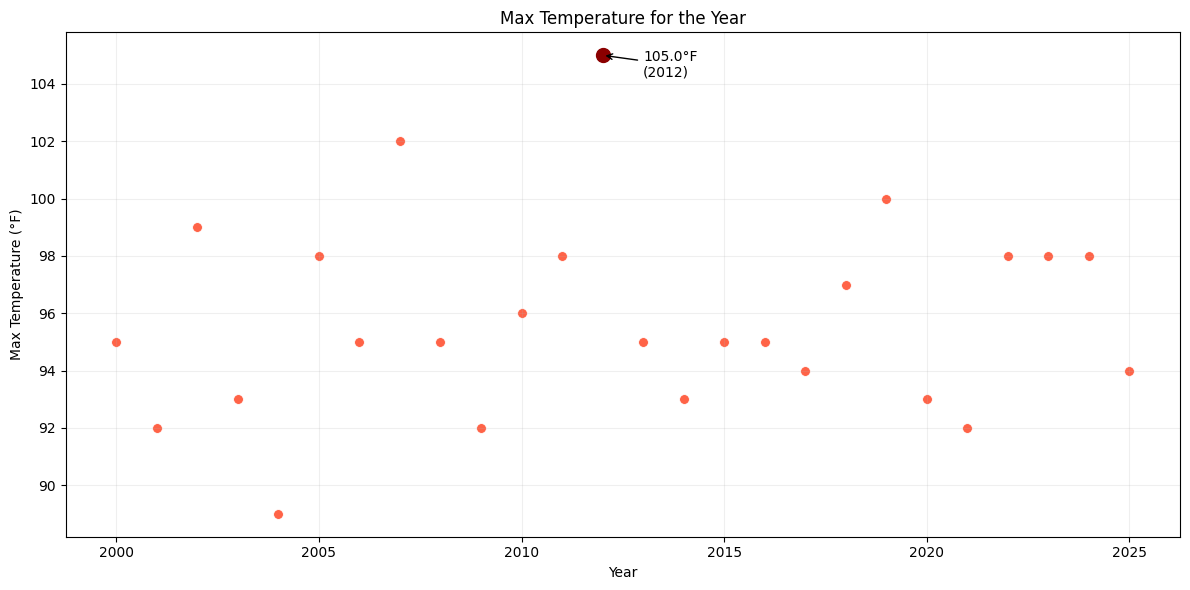

In [25]:
# What is the MAX temp for the year?

max_temp_by_year = df_main.groupby('YEAR')['TMAX'].max().reset_index()
max_tmax_value = max_temp_by_year['TMAX'].max()
max_tmax_year = max_temp_by_year.loc[max_temp_by_year['TMAX'].idxmax(), 'YEAR']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=max_temp_by_year, x='YEAR', y='TMAX', marker='o', s=50, color='tomato')
plt.scatter(max_tmax_year, max_tmax_value, color='darkred', s=100, label=f'Max: {max_tmax_value:.2f}°F')
plt.annotate(f'{max_tmax_value}°F\n({int(max_tmax_year)})',
             xy=(max_tmax_year, max_tmax_value),
             xytext=(max_tmax_year + 1, max_tmax_value - .75),
             arrowprops=dict(facecolor='steelblue', arrowstyle='->'),
             fontsize=10)

plt.title("Max Temperature for the Year")
plt.xlabel('Year')
plt.ylabel('Max Temperature (°F)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

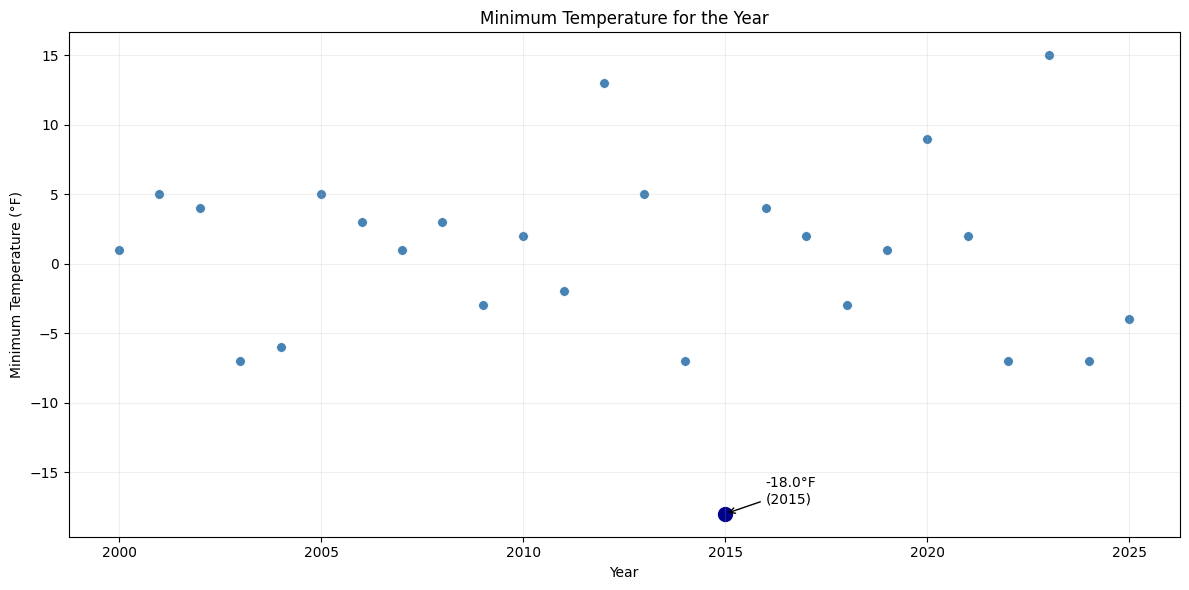

In [26]:
# Now we might as well look at what the MIN temp was for each year

min_temp_by_year = df_main.groupby('YEAR')['TMIN'].min().reset_index()
min_tmin_value = min_temp_by_year['TMIN'].min()
min_tmin_year = min_temp_by_year.loc[min_temp_by_year['TMIN'].idxmin(), 'YEAR']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=min_temp_by_year, x='YEAR', y='TMIN', marker='o', s=50, color='steelblue')
plt.scatter(min_tmin_year, min_tmin_value, color='darkblue', s=100, label=f'Min: {min_tmin_value:.2f}°F')
plt.annotate(f'{min_tmin_value}°F\n({int(min_tmin_year)})',
             xy=(min_tmin_year, min_tmin_value),
             xytext=(min_tmin_year + 1, min_tmin_value + .75),
             arrowprops=dict(facecolor='darkblue', arrowstyle='->'),
             fontsize=10)
plt.title('Minimum Temperature for the Year')
plt.xlabel('Year')
plt.ylabel('Minimum Temperature (°F)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Annual Trends for 2000 - 2024

*I did not include the data for 2025 in this chart.*

This graph charts the average **max**, **min**, and **average** temperature for each year between 2000 and 2024.  While there appears to be an upward trend, it is interesting to see how the averages for the years after the peaks and valleys seem to jump up (or down) and then maintain for a bit before jumping up or down again.

It might be worth noting:

-  The year with the highest max is at one of the peaks for average max temp
-  The year with the lowest min is not at a valley for the lowest min temp.

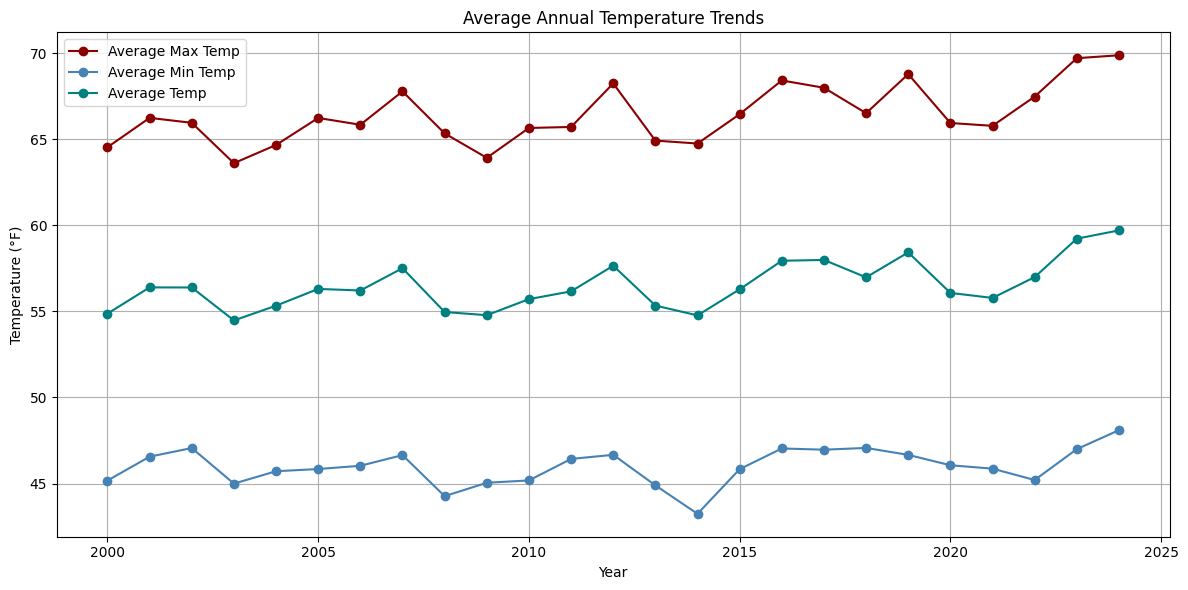

In [27]:
current_data = df_main[df_main['DATA_SOURCE'] == 'current']

yearly_current = current_data.groupby('YEAR').agg({
    'TMAX': 'mean',
    'TMIN': 'mean',
    'TEMP': 'mean'  # optional if you want to include it
}).reset_index()

yearly_current_wo25 = yearly_current[yearly_current['YEAR'] != 2025]

plt.figure(figsize=(12, 6))
plt.plot(yearly_current_wo25['YEAR'], yearly_current_wo25['TMAX'], label='Average Max Temp', color='darkred', marker='o')
plt.plot(yearly_current_wo25['YEAR'], yearly_current_wo25['TMIN'], label='Average Min Temp', color='steelblue', marker='o')
plt.plot(yearly_current_wo25['YEAR'], yearly_current_wo25['TEMP'], label='Average Temp', color='teal', marker='o')
plt.title('Average Annual Temperature Trends')
plt.xlabel('Year')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Heatmap of the Average Seasonal Temperatures

*For this chart, I also chose to not include the 2025 data.*

I think this chart is pretty interesting to consider.  It definitely looks like our winter averages are trending upwards, with the occasional dips.  But if you look at our summer temps, they tend to stay in similar ranges, while still trending upwards.  It's a much more gradual increase with the summer temperatures.

The year with the coldest winter average, also happened to have the warmest summer average.

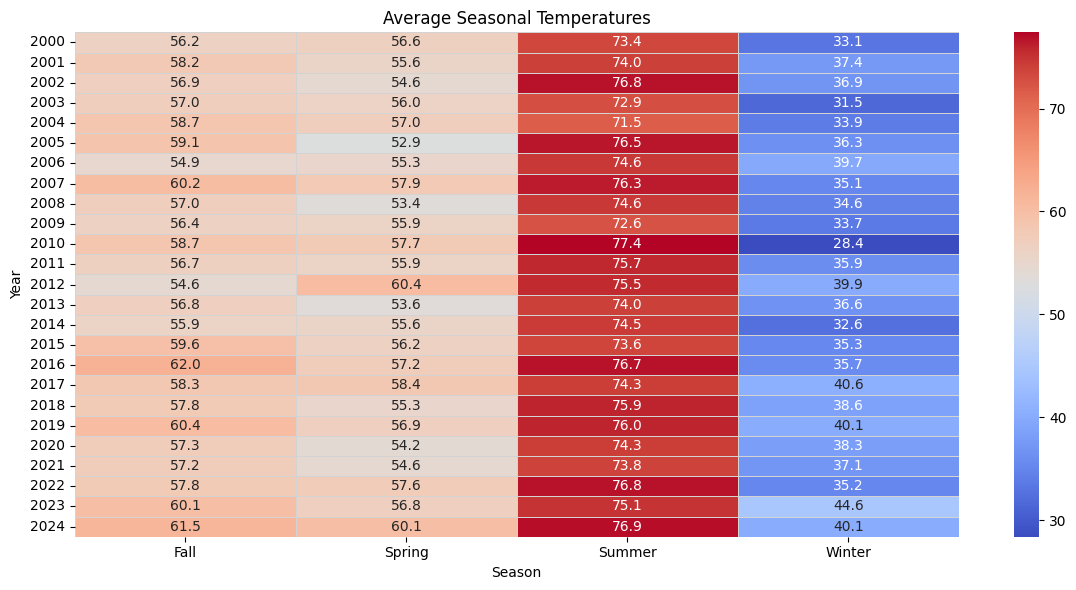

In [28]:
df_seasonal = df_main[df_main['DATA_SOURCE'] == 'current']

seasonal_avg = df_seasonal.groupby(['YEAR', 'SEASON']).agg({
    'TMAX': 'mean',
    'TMIN': 'mean',
    'TEMP': 'mean'
}).round(1).reset_index()

# Removing 2025 from the data as it is not complete
seasonal_avg = seasonal_avg[seasonal_avg['YEAR'] != 2025]

heatmap_data = seasonal_avg.pivot(index='YEAR', columns='SEASON', values='TEMP')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5, linecolor='lightgrey')
plt.title('Average Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


### Seaonal Total Percipitation 

We have two sets of percipiation data available, but we are using the main one provided by the Bluegrass Airport.  The other data is mostly from the airport, but also includes some other stations that are in the Lexington region & are not 100% complete.  I did include the data for 2025 in this chart.

There are two very obvious outliers in this chart: Summer 2015 and Winter 2016.  You can also see that Spring for 2015 had a slightly higher than average total as well.

What is interesting is if you look at this and compare it to the graphs above:

2015:
- Was the year with the lowest min temp (coldest year) at a -18
- Pretty average overall winter temp average, as well as an average but slightly cooler summer average temp.

2016:
- Had a warmer summer and fall average; the fall average for 2016 is actually the warmest fall avg.
- The winter was pretty mid range average as well.

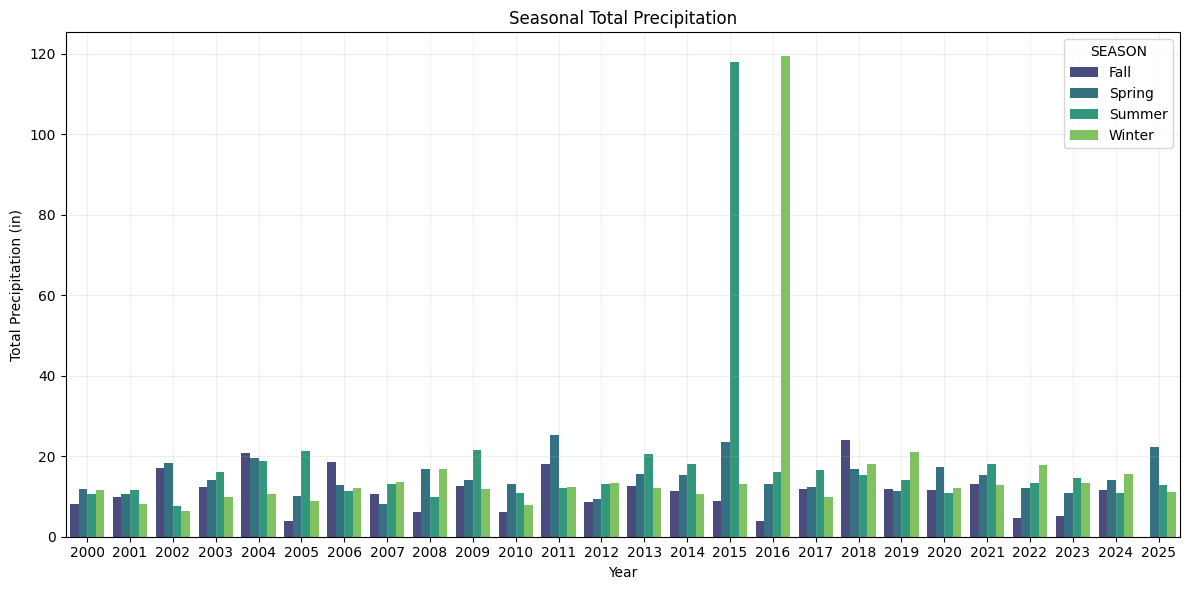

In [29]:
prcp_seasonal = df_seasonal.groupby(['YEAR', 'SEASON']).agg({
    'PRCP': 'sum'
}).round(2).reset_index()

prcp_seasonal.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=prcp_seasonal, x='YEAR', y='PRCP', hue='SEASON', palette='viridis')
plt.title('Seasonal Total Precipitation')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (in)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

----
## Overall Insight

I really found this data to be pretty interesting.  With Kentucky being a landlock state, our temperatures are less effected by the ocean and may tend to more of the extremes compared to some coastal states.  If you look at data for the entire USA, you'll see the centermost states tend to have some of the hottest summers and coldest winters.

Our average temperatures are definitely on an upwards trend.  While a degree difference may not seem like much, it can be pretty catastrophic world wide.

Something I still find really interesting after all of this is the discrepency between the lowest min temp and the next lowest min temp.  There's such a huge difference between the two!  And on the flip side, the highest max compared to the next highest max temp is only a few degree difference..
